In [46]:
import numpy as np
import pandas as pd
import os

class ModelData:
    def __init__(self):
        self.name = None
        self.gem = None
        self.gem_id = None
        self.pos = None
        self.people = None
        self.phases = None
        self.status = None
        self.timestep = None

        self.exposed = None
        self.infected = None
        self.recovered = None

# Load data
def load_data(seed, run, intervention):
    path = os.getcwd() + '/Data/Model_V1/Data/'

    data = ModelData()
    data.name = intervention
    data.gem = pd.read_pickle(path + 'Gemeenten.pkl')
    data.gem_id = pd.read_pickle(path +'GemeentenID.pkl')
    data.pos = np.load(path + 'Positions.npy')

    path = os.getcwd() + '/Data/Model_V1/Data/High/Seed_' + str(seed) + '/'

    data.people = pd.read_pickle(path + 'PeopleDF.pkl')

    data.phases = pd.read_pickle(path + 'Runs_' + intervention + '/Phases_' + str(run) + '.pkl')
    data.status = np.load(path + 'Runs_' + intervention + '/Status_' + str(run) + '.npz')
    data.timestep = np.loadtxt(path + 'Runs_' + intervention + '/Timestep_' + str(run))

    return data

In [47]:
seeds = [0]
runs = [0]
interventions = ['ref', 'behavior', 'working', 'school']

data_points = []
for seed in seeds:
    for run in runs:
        for intervention in interventions:
            data_points.append(load_data(seed, run, intervention))

print('Succesfully loaded ' + str(len(data_points)) + ' data points')

Succesfully loaded 4 data points


In [48]:
# Print info for a specific datapoint
data = data_points[0]
print('name: ', data.name)
print('gem: ', data.gem.shape)
print('gem_id: ', data.gem_id.shape)
print('pos: ',data.pos.shape)
print('people: ',data.people.shape)
print(data.status.files)

# timesteps: n_days * 24
print('timesteps: ', data.status['indptr'].shape)
print('status: ', data.status['data'].shape)

name:  ref
gem:  (380, 1)
gem_id:  (380, 1)
pos:  (7, 24, 170721)
people:  (170721, 382)
['indices', 'indptr', 'format', 'shape', 'data']
timesteps:  (2881,)
status:  (40146882,)


In [69]:
# Compute infected cases per timestep
for data in data_points:
    timesteps = data.status['indptr'].shape[0] -1
    raw_data = data.status['data']
    indptr = data.status['indptr']

    data.exposed = np.zeros(timesteps)
    data.infected = np.zeros(timesteps)
    data.recovered = np.zeros(timesteps)
    for t in range(0, timesteps):
        timestamp_row = raw_data[indptr[t] : indptr[t + 1]]
        data.exposed[t] = np.count_nonzero(timestamp_row == 1)
        data.infected[t] = np.count_nonzero(timestamp_row == 2)
        data.recovered[t] = np.count_nonzero(timestamp_row == 3)

# Minimum at 107
print(data_points[0].infected.size)
print(np.argmin(data_points[0].infected))

2880
3


d:\University\thesis\covid-gravity-model\venv\lib\site-packages\numpy\core\fromnumeric.py:59: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)


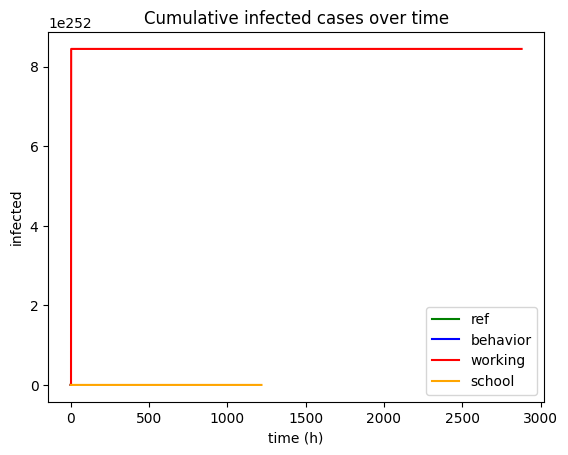

In [70]:
import matplotlib.pyplot as plt

# For easy comparison to figure 3 of the paper.
color_map = {
    'ref': 'green',
    'school': 'orange',
    'behavior': 'blue',
    'working': 'red'
}

plt.title('Cumulative infected cases over time')
plt.xlabel('time (h)')
plt.ylabel('infected')
#plt.yscale('log')
for data in data_points:
    plt.plot(np.arange(0, len(data.infected)), np.cumsum(data.infected), label=data.name, color=color_map[data.name])
plt.legend()
plt.show()